# Mapping the Global Water Investment Opportunity Space for Sustainable Water Development

***
<font color=red>Title: Mapping the Global Water Investment Opportunity Space for Sustainable Water Development  
Author: DBPR  
Date: April 2, 2023  

This code was developed between October 2021 and March 2023 by DBPR and includes the development and creation of all raster and tabular data included in the manuscript with same title.  </font>
***

The following data were downloaded, processed,and assembled during the project period. All input datasets are resampled from their native formats to 6-minute resolution GeoTIFF raster format using a standard reprojection and warping utility (GDAL Warp).

<b>Water Threats</b>

Water threat indicators from Vörösmarty et al 2010 (available from https://riverthreat.net/data.html), noted below, are resampled to 6-minute grid cell resolution using a nearest-neighbor algorithm.

| Vörösmarty et al 2010 dataset | Acronym
| --- | --- |
| Incident Human Water Security Threat | HWS
| Adjusted Human Water Security Threat | aHWS
| Investment Benefit Factor | IBF
| Water Resource Development Threat Theme | WRD
| Pollution Threat Theme | PO
| Catchment Disturbance Threat Theme | CD
| Biotic Factor Threat Theme | BF


<b>Contemporary Climate Variability</b>

Contemporary Climate Variability indicator is developed by calculating the intra- and inter annual variability in available water resources from CUNY WBM water balance model monthly and annual river discharge outputs using the TerraClimate high resolution data set of monthly climate forcings (Abatzoglou, et al. 2018, Wisser et al. 2010) at 6-minute grid cell resolution for the period 2000-2020. Coefficient of Variation (CV) indicators are calculated across the time periods specified as (Standard Deviation / Mean). The CV indicators are then ranked with a cumulative dstribution function (CDF) on a continuous 0-1 scale of low to high climate variability threat using the rankCDF function in this Notebook this identifying areas most vulnerable to large shifts in water availability due to seasonality (intra-annual) and longer term (30-year inter-annual) climate patterns. 
 
Existing Juypter Notebook code was used to create the Climate Variability CDF data which is directly imported into this code from the Model_Input/WBM/WBM_TerraClimate2000-2020_Q_DIST_CDF_InterIntra_6min.tif. Seperate rasters for the intra- and inter- annual Climate Variability CDFs are included for completeness. 

<b>Country Designations and Spatial Boundaries</b>

Country boundaries are derived from the GADM database (avaiable at https://gadm.org/data.html) and converted to raster format at 6-minute resolution for processing with raster water threat data. Smaller nations and island nations not present in the water threat raster dataset are not included from the GADM database. 

<b>Global Innovation Index Data</b>

Global Innovation Index country score data for 2022 was downloaded from https://tind.wipo.int/record/46596. Scores were linearly rescaled and converted to a fraction (divide by 100) so the maximum score was 1.0. Countries that were excluded from the 2022 GII listing due to insufficient data but assigned a score in a previous year were assigned a GII score associated with the same ranked position for that country from the most recent year of record. Countries omitted from the GII analysis were assigned the adjusted GII value associated with the lowest ranking score for each omitted country’s UN designated regional cohort.The GII tabular data is linked to the GADM country boundaries for spatial processing.

<b>Population Distribution</b>

Local Population for 2020 is from GPWv4 database (CIESIN 2018) and downloaded via https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev11. Downstream population is processed via a routing algorithms using the CUNY WBM RGIS system and the WBM flow data described above.

<b>WIN and PrivateOI Indicators</b>

The contemporary Climate Variability indicator is applied to the HWS and threat theme indicators from Vörösmarty et al 2010 above to create the WIN indicators measuring the combined impacts of climate variability and water threats for contemporary conditions. The spatial GII indicator is applied to the WIN indicators to create the PrivateOI indicators identifying the impacts of enabling environment state on private sector investment opportunties. WIN and PrivateOI indicators are ranked on a continuous 0-1 scale of low to high needs/opportunities using the rankCDF function in this Notebook.

<b>Casting Water WIN and PrivateOI in Terms of Water Resource Areas Supporting Downstream Populations</b>

We use the WIN and PrivateOI indicators described above to map population downstream of water source areas under varying levels of needs and opportunities. We map the geography of population downstream of water source areas under low, moderate, and high scores for each of the WIN and PrivateOI indicators under contemporary conditions. 


References:

Abatzoglou, J. T., Dobrowski, S. Z., Parks, S. A. & Hegewisch, K. C. TerraClimate, a high-resolution global dataset of monthly climate and climatic water balance from 1958–2015. Sci. Data 5, 170191 (2018).

Center for International Earth Science Information Network - CIESIN - Columbia University. 2018. Gridded Population of the World, Version 4 (GPWv4): Population Density, Revision 11. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC).

Dutta, S., Lanvin, B., Wunsch-Vincent, S., León, L. R. & World Intellectual Property Organization. Global innovation index 2022. doi:10.34667/TIND.46596

GADM. GADM database of Global Administrative Areas. https://gadm.org/data.html (2016).

Vorosmarty, C.J.,  P.B. McIntyre, M.O. Gessner, D. Dudgeon, A. Prusevich, P. Green, S. Glidden, S.E. Bunn, C.A. Sullivan, C. Reidy Liermann, and P.M. Davies. Nature 467, 555-561 (30 September 2010) doi:10.1038/nature09440.

Wisser, D., B. M. Fekete, C. J. Vörösmarty, and A. H. Schumann. “Reconstructing 20th Century Global Hydrography: A Contribution to the Global Terrestrial Network- Hydrology (GTN-H).” Hydrology and Earth System Sciences 14, no. 1 (January 6, 2010): 1–24. https://doi.org/10.5194/hess-14-1-2010.

****
# Modules and Functions

In [34]:
import numpy as np
import pandas as pd

import scipy
from scipy.stats import rankdata
import scipy.ndimage as nd

from osgeo import gdal, gdal_array, osr, ogr
from osgeo.gdalconst import *

import subprocess as sp
import os
import xlsxwriter
import matplotlib.pyplot as plt

## Single band numpy array to GeoTiff file

In [35]:
def save2File(rA, outname, nrows, ncols, geo_transform):  # Resolution for the 6min
    # create the output image
    # Note that in the geo transform the third and sixth parameters are equal to the Arc/Info generate fishnet
    # Y-coordinate paramenter (defining the rotation of the final grid)
    # LCORD
    outDs = gdal.GetDriverByName('GTiff').Create(outname, ncols, nrows, 1, gdal.GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(rA)
    outDs.SetGeoTransform(geo_transform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    outDs.SetProjection(srs.ExportToWkt())
    outDs = None

    """
    geotransform[0] = top left x
    geotransform[1] = w-e pixel resolution
    geotransform[2] = 0
    geotransform[3] = top left y
    geotransform[4] = 0
    geotransform[5] = n-s pixel resolution (negative value)
    """

****
## MultiBand numpy array to GeoTiff

In [36]:
def CreateMultiGeoTiff(Array, Name, driver, NDV, GeoT, Projection, DataType):
    Array[np.isnan(Array)] = NDV
    DataSet = gdal.GetDriverByName(driver).Create(Name, Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoT)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(Projection)
    DataSet.SetProjection(srs.ExportToWkt() )
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
    DataSet.FlushCache()
    return Name

## Rank Cumulative Distribution Function (CDF)

In [37]:
def rankCDF(array, min):
    array[np.isnan(array)] = 0    
    rank = np.reshape((rankdata(array, method='dense') - 1), array.shape)
    rank = np.where(array == min, 0.000, rank)
    cdf = rank / np.amax(rank)
    
    return cdf

In [38]:
def compute_normalized_rank(data):
    """Return normalized ranks for the given data."""
    rank = np.reshape(rankdata(data, method='dense') - 1, data.shape)
    rank = np.where(np.isin(rank, [0.000, 1.000]), 0.000, rank)
    return rank / np.amax(rank)

## Identify Modes

The function assumes input ids are given sequentially starting from 1

In [39]:
def find_group_modes_vec(data, ID):
    # Assume ids are given sequentially starting from 1
    data_uniq, data_idx = np.unique(data, return_inverse=True)
    id_uniq, id_idx = np.unique(ID, return_inverse=True)
    n = len(data_uniq)
    m = len(id_uniq)
    grouped = data_idx + (n * np.arange(m))[id_idx]
    counts = np.bincount(grouped, minlength=n * m).reshape(m, n)

    return data_uniq[counts.argmax(1)]

## Assign Bubble Color by World Bank Income Class

In [40]:
def bubbcol(row):
    if (row['WBRegion'] == 'Low Income'):
        regcolor = 'red'
        return str(regcolor)
    elif (row['WBRegion'] == 'Middle Income'):
        regcolor = 'gold'
        return str(regcolor)
    elif (row['WBRegion'] == 'High Income'):
        regcolor = 'cornflowerblue'
        return str(regcolor)
    else:
        return 'gray'

# Global Variables, Definitions, Datasets

## Global Pathways to Data files

In [41]:
main = os.getcwd( ) + '/'

model_input = str(main) + str("Data/Model_Input/")
model_output = str(main) + str("Data/Model_Output/")

cellarea = str(model_input) + str("cellarea/")
popdir = str(model_input) + str("population/")
TCWBM_dir = str(model_input) + str("WBM/")
threat_dir = str(model_input) + str("RiverThreats/")
gadm_dir = str(model_input) + str("GADM/")
gii_dir = str(model_input) + str("GII/")
susinvopp_gisdata = str(model_output) + str("rasters/")
susinvopp_tabgraph_main = str(model_output) + str("tables/")


## Explicitely define projection information for 6 minute rasters

In [42]:
xll = -180.0
yll = -90
yur = 90
cellsize = 0.1
ncols = 3600
nrows = 1500
nodata = -9999
geotr = ([ xll, cellsize, 0, yur, 0, -0.1 ])

# DROP LAST 300 NROWS SO GRIDS MATCH COMPASS RUNOFF (-60 LAT)
n = 300

## Import Cellarea Raster

Raster resolution=6-min, units=km2

In [43]:
fin = 'CellArea_6m.tif'
ds = gdal.Open(str(cellarea) + str(fin))
CellArea = np.array(ds.GetRasterBand(1).ReadAsArray())
CellArea[np.isnan(CellArea)] = 0

## Import Local and Downstream Population Rasters

Raster resolution=6-min, units=population counts

In [44]:
fin = 'dwnpop_2020_gpwv4_TerraClimate_aLTM2000-2020_6min.tif'
ds = gdal.Open(str(popdir) + str(fin))
pop = np.array(ds.GetRasterBand(1).ReadAsArray())
pop[np.isnan(pop)] = 0
pop = np.where(pop <= -9999, 0.00, pop)

popden = pop / CellArea

fin = 'gpw_v4_population_count_rev11_2020_6min.tif'
#fin = 'gpw4_poptot_2020_6m.tif'
ds = gdal.Open(str(popdir) + str(fin))
localpop = np.array(ds.GetRasterBand(1).ReadAsArray())
localpop[np.isnan(localpop)] = 0
localpop = np.where(localpop <= -9999, 0.00, localpop)
localpop = localpop[:-n, :]

localpopden = localpop / CellArea

## Import INTER/INTRA-ANNUAL CDF from WBM_TerraClimate analysis 2000-2020

WBM discharge data was accessed from CUNY servers using the Jupyter Notebook script

Raster resolution=6-min, units=unitless

In [45]:
ds = gdal.Open(TCWBM_dir + 'WBM_TerraClimate2000-2020_Q_DIST_CDF_InterIntra_6min.tif')
ClimateVulnNORM_CDF = np.array(ds.GetRasterBand(1).ReadAsArray())

## Define which Water Threat to run from list

The code can be run to produce all WIN and PrivateOI manuscript outputs for the total Human Water Security (HWS) threat as well as the four water threat themes (WRD, PO, CD, BF) by selecting the individual threat from the input list below entering the corresponding listnum variable. The threat_name variable is initialized to the HWS threat (listnum = 0). To run the code for any of the water threat themes you need to change the listnum varilable to one of the numbers given below:

| Water Threat | listnum
| --- | --- |
| Total Human Water Security (HWS) | 0
| Water Resource Development (WRD) | 1
| Pollution (PO) | 2
| Catchment Disturbance (CD) | 3
| Biotic Factors (BF) | 4

Water Threat List <a id='goto_threat_list'></a>

In [46]:
input_list = ["hws_6m_nn", "wrd_cdf_6m", "po_cdf_6m", "cd_cdf_6m", "bf_cdf_6m"]

listnum = 0
threat_name = (input_list[listnum])

## Import incident (HWS) and adjusted (aHWS) River Threats, Infrastructure Adjustment Factor (IBF) and River Threat Themes (WRD, PO, CD, BF)

In [47]:
name = str(threat_dir) + str(threat_name) + '.tif'

ds = gdal.Open(str(name))
ahws = np.array(ds.GetRasterBand(1).ReadAsArray())
ahws[np.isnan(ahws)] = 0
ahws = np.where(ahws < 0, 0.00, ahws)
ahws = ahws[:-n, :]

fin = 'hws_6m_nn.tif'
ds = gdal.Open(str(threat_dir) + str(fin))
ihws = np.array(ds.GetRasterBand(1).ReadAsArray())
ihws = ihws[:-n, :]
hws_msk = ihws
hws_msk = np.where(np.isnan(ihws), 1, 0)
hws_msk = np.where(hws_msk < 0, 1, 0)

name = str(threat_dir) + 'wrd_cdf_6m.tif'
ds = gdal.Open(str(name))
wrd_cdf_6m = np.array(ds.GetRasterBand(1).ReadAsArray())
wrd_cdf_6m[np.isnan(wrd_cdf_6m)] = 0
wrd_cdf_6m = np.where(wrd_cdf_6m < 0, 0.00, wrd_cdf_6m)
wrd_cdf_6m = wrd_cdf_6m[:-n, :]

name = str(threat_dir) + 'po_cdf_6m.tif'
ds = gdal.Open(str(name))
po_cdf_6m = np.array(ds.GetRasterBand(1).ReadAsArray())
po_cdf_6m[np.isnan(po_cdf_6m)] = 0
po_cdf_6m = np.where(po_cdf_6m < 0, 0.00, po_cdf_6m)
po_cdf_6m = po_cdf_6m[:-n, :]

name = str(threat_dir) + 'cd_cdf_6m.tif'
ds = gdal.Open(str(name))
cd_cdf_6m = np.array(ds.GetRasterBand(1).ReadAsArray())
cd_cdf_6m[np.isnan(cd_cdf_6m)] = 0
cd_cdf_6m = np.where(cd_cdf_6m < 0, 0.00, cd_cdf_6m)
cd_cdf_6m = cd_cdf_6m[:-n, :]

name = str(threat_dir) + 'bf_cdf_6m.tif'
ds = gdal.Open(str(name))
bf_cdf_6m = np.array(ds.GetRasterBand(1).ReadAsArray())
bf_cdf_6m[np.isnan(bf_cdf_6m)] = 0
bf_cdf_6m = np.where(bf_cdf_6m < 0, 0.00, bf_cdf_6m)
bf_cdf_6m = bf_cdf_6m[:-n, :]

fin = str(threat_dir) + 'infadj_6m_nn.tif'
ds = gdal.Open(str(fin))
ibf = np.array(ds.GetRasterBand(1).ReadAsArray())
ibf[np.isnan(ibf)] = 0
ibf = np.where(ibf < 0, 0, ibf)
ibf = ibf[:-n, :]

## Calculate Adjusted Threat for HWS and Threat Themes using IBF

We calculate the adjusted water threat by applying the Infrastructure Benefit Factor (IBF) as per Vorosmarty et al, 2010 for total HWS and each threat theme.

In [48]:
ahws = ahws * ( 1 - ibf)
ahws = rankCDF(ahws, 1.000)

adj_ihws = ihws * ( 1 - ibf)
adj_ihws = rankCDF(adj_ihws, 1.000)

adj_wrd = wrd_cdf_6m * ( 1 - ibf)
adj_wrd = rankCDF(adj_wrd, 1.000)
adj_po = po_cdf_6m * ( 1 - ibf)
adj_po = rankCDF(adj_po, 1.000)
adj_cd = cd_cdf_6m * ( 1 - ibf)
adj_cd = rankCDF(adj_cd, 1.000)
adj_bf = bf_cdf_6m * ( 1 - ibf)
adj_bf = rankCDF(adj_bf, 1.000)

## Calculate Threat Theme Downstream Population Impacted

Downstream population impacted under each threat theme is apportioned relative to each theme's contribution to the total HWS threat prior to CDF ranking.

In [49]:
with np.errstate(invalid='ignore'):
    with np.errstate(divide='ignore'):
        ihws_temp = (po_cdf_6m * 0.35 ) + (wrd_cdf_6m * 0.41 ) + (cd_cdf_6m * 0.18 ) + (bf_cdf_6m * 0.06)
        po_frac = np.where(ihws_temp == 0, 0, (po_cdf_6m * 0.35 ) / ihws_temp)
        wrd_frac = np.where(ihws_temp == 0, 0, (wrd_cdf_6m * 0.41) / ihws_temp)
        cd_frac = np.where(ihws_temp == 0, 0, (cd_cdf_6m * 0.18 ) / ihws_temp)
        bf_frac = np.where(ihws_temp == 0, 0, (bf_cdf_6m * 0.06) / ihws_temp)

po_pop = po_frac * pop
wrd_pop = wrd_frac * pop
cd_pop = cd_frac * pop
bf_pop = bf_frac * pop

## Import Country Boundaries from GADM

Country boundaries are derived from the GADM database (avaiable at https://gadm.org/data.html) and converted to raster format at 6-minute resolution for processing with the raster water threat data. Smaller nations and island nations not present in the water threat raster dataset are not included from the GADM database. Fraction of area in each country with river threat data is also calculated here.

In [50]:
fin = 'gadm_6m.tif'
ds = gdal.Open(str(gadm_dir) + str(fin))
CountryBnd = np.array(ds.GetRasterBand(1).ReadAsArray())
CountryBnd[np.isnan(pop)] = 0

ahws_area = np.where(ahws <= 0.0000, 0, CellArea)
ahws_frac = scipy.ndimage.sum(ahws_area, labels=CountryBnd, index = CountryBnd) / scipy.ndimage.sum(CellArea, labels=CountryBnd, index = CountryBnd)

## Assigning Water Threats to non-Flowing Regions with Population

The Vorosmarty et al 2010 water threat analysis was confined to the discharging landmass and did not consider very dry or arid areas lacking local surface water resources such as local storage, deep groundwater or reservoirs. We accounted for aHWS and WRD Theme Threat to River threat scores in these regions by based on an assumption of absolute human water stress driver threat in the water resource development theme. Adjustments for threat abatement from investments in water infrastructure and management for the non-flowing areas were applied based on a country average Investment Benefit Factor (IBF) value used in the original analysis for threats in these non-flowing areas.

In [51]:
# Calculate mean country IBF values
CountryBnd_ibf = np.where(ibf == 0, 0, CountryBnd)
ibfstat = scipy.ndimage.mean(ibf, labels=CountryBnd_ibf, index = CountryBnd_ibf)
ibfstat = scipy.ndimage.maximum(ibfstat, labels=CountryBnd, index = CountryBnd)
# Saudi Arabia has no data for IBF; use mean of adjacent countries as proxy
ibfstat = np.where(CountryBnd == 682, 0.39, ibfstat)

sum_index = scipy.ndimage.sum(ibf, CountryBnd, CountryBnd)
with np.errstate(invalid='ignore'):
    with np.errstate(divide='ignore'):
        cnt_index = (scipy.ndimage.sum(np.where(ibf ==0, 0, CountryBnd), CountryBnd, CountryBnd))/ CountryBnd
        ibfstat_index = sum_index / cnt_index
# Saudi Arabia has no data for IBF; use mean of adjacent countries as proxy
ibfstat_index = np.where(CountryBnd == 682, 0.39, ibfstat_index)

Threat_noflow = 1.0
Threat_noflow_max = scipy.ndimage.maximum(ahws)
Threat_noflow_min = scipy.ndimage.minimum(ahws)

# Create threat and driver themes
Threat_noflow_max = scipy.ndimage.maximum(adj_ihws)
noflow_threat = np.where(adj_ihws <= 0.0000, np.where(pop > 0.0000, np.where(ibfstat > 0.01, Threat_noflow_max * (1 - ibfstat), 0),  0), 0)
threat = adj_ihws + noflow_threat
threat_HWS = threat

Threat_noflow_max = scipy.ndimage.maximum(adj_wrd)
noflow_theme = np.where(adj_wrd <= 0.0000, np.where(pop > 0.0000, np.where(ibfstat > 0.01, Threat_noflow_max * (1 - ibfstat), 0),  0), 0)
theme = adj_wrd + noflow_theme  
theme_wrd = theme

ahwsstat = scipy.ndimage.mean(adj_po, labels=CountryBnd_ibf, index = CountryBnd_ibf)
ahwsstat_mean = scipy.ndimage.mean(ahwsstat, labels=CountryBnd, index = CountryBnd)
ahwsstat_mean = np.where(CountryBnd == 682, 0, ahwsstat_mean)
noflow_theme = np.where(adj_po <= 0.0000, np.where(pop > 0.0000, np.where(ibfstat > 0.01, ahwsstat_mean * (1 - ibfstat), 0),  0), 0)
theme = adj_po + noflow_theme  
theme_po = theme

ahwsstat = scipy.ndimage.mean(adj_cd, labels=CountryBnd_ibf, index = CountryBnd_ibf)
ahwsstat_mean = scipy.ndimage.mean(ahwsstat, labels=CountryBnd, index = CountryBnd)
ahwsstat_mean = np.where(CountryBnd == 682, 0, ahwsstat_mean)
noflow_theme = np.where(adj_cd <= 0.0000, np.where(pop > 0.0000, np.where(ibfstat > 0.01, ahwsstat_mean * (1 - ibfstat), 0),  0), 0)
theme = adj_cd + noflow_theme  
theme_cd = theme

ahwsstat = scipy.ndimage.mean(adj_bf, labels=CountryBnd_ibf, index = CountryBnd_ibf)
ahwsstat_min = scipy.ndimage.minimum(ahwsstat, labels=CountryBnd, index = CountryBnd)
ahwsstat_min = np.where(CountryBnd == 682, 0, ahwsstat_mean)
noflow_theme = np.where(adj_bf <= 0.0000, np.where(pop > 0.0000, np.where(ibfstat > 0.01, ahwsstat_min * (1 - ibfstat), 0),  0), 0)
theme = adj_bf + noflow_theme  
theme_bf = theme


## Linking Enabling Environment data to GADM country boundaries

The ranked Enabling Environment score data (GII, IWRM, Adaptive Capacity) score data in spreadhseet is linked to the GADM spatial raster 

In [52]:
EE_type = "GII"
#EE_type = "IWRM"
#EE_type = "AdaptiveCap"

susinvopp_gisdata = str(model_output) + str("rasters/") + str(EE_type) + str("/")
susinvopp_tabgraph_main = str(model_output) + str("tables/") + str(EE_type) + str("/")

# Read the IWRM data Excel spreadsheet into a pandas dataframe
iwrm_file = str(model_input) + "IWMR/IWRM_country-database-full.xlsx"
sheet_name = "ISO_LOOKUP"
columns_to_read = ['ISO', 'IWRMScore']
pd_iwmr = pd.read_excel(iwrm_file, sheet_name=sheet_name, usecols=columns_to_read)
pd_iwmr['IWRM_Adj'] = pd_iwmr['IWRMScore'] / 100

ac_file = str(model_input) + "Adaptive_Capacity/avg_ac_gadmISO.xlsx"
sheet_name = "Sheet1"
columns_to_read = ['ISO_NUM', 'Adaptive Capacity Avg', 'Adaptive Capacity Lin']
pd_ac = pd.read_excel(ac_file, sheet_name=sheet_name, usecols=columns_to_read)
pd_ac['AC_Adj'] = pd_ac['Adaptive Capacity Avg']
pd_ac = pd_ac[(pd_ac['ISO_NUM'] > 0)]
max_val = pd_ac['AC_Adj'].max()
pd_ac['AC_Adj_Lin'] = pd_ac['AC_Adj'] / max_val

#print(pd_ac)

gii_file = str(gii_dir) + str('All_Years_Final_GII.xlsx')
columns_to_read = ['GADMID', 'ISO', 'ISO_NUM', 'Country Name', 'WBRegion', 'Region', 'Achievers', 'New_Score2023_fill', 'GII_Adj', 'GII_Adj_ranks', 'GII_Adj_Lin']
sheet_name = 'Sheet1'
pd_GII = pd.read_excel(gii_file, sheet_name=sheet_name, usecols=columns_to_read)
pd_GII['ID'] = pd_GII['GADMID']
#pd_GII['Region'] = pd_GII['WBRegion']
pd_GII['Score'] = pd_GII['New_Score2023_fill']
pd_GII['Economy'] = pd_GII['Country Name']
pd_GII = pd_GII[(pd_GII['ID'] != 0)]

if EE_type == 'GII':
    pd_GII['EE_Adj'] = pd_GII['GII_Adj_Lin']
    #pd_GII['EE_Adj'] = pd_GII['New_Score2023_fill'] / 100
elif EE_type == 'IWRM':
    pd_iwmr['EE_Adj'] = pd_iwmr['IWRMScore'] / 100
elif EE_type == 'AdaptiveCap':
    pd_ac['EE_Adj'] = pd_ac['AC_Adj_Lin']
    #pd_ac['EE_Adj'] = pd_ac['Adaptive Capacity Avg']
    
# 1. Join the two dataframes based on the 'ISO' column
pd_combined1 = pd.merge(pd_iwmr, pd_GII, on='ISO', how='outer')
pd_combined = pd.merge(pd_ac, pd_combined1, on='ISO_NUM', how='outer')
#print(pd_combined)

#print(pd_GII)
gii = CountryBnd
for index, row in pd_combined.iterrows():
    gii = np.where(gii == row['ID'], row['EE_Adj'], gii)
    
# gii[np.isnan(gii)] = 0
# gii = np.where(gii <= -9999, 0.00, gii)

#giiWIN = np.where(gii == 0.00, 0.855, ( 1.0 - (gii - 0.328) + 0.145))
giiWIN = gii

#print(pd_combined['WBRegion'])

In [53]:
if threat_name == 'hws_6m_nn':
    ahws = threat_HWS
    str(model_output) + str("rasters/") + str(EE_type) + str("/HWS/")
    susinvopp_tabgraph = str(model_output) + str("tables/") + str(EE_type) + str("/HWS/")
    susinvopp_tabname = str("Country_Ranks.xlsx")
    susinvopp_out = str(model_output) + str("rasters/") + str(EE_type) + str("/HWS/")
    susinvopp_graphics = str(model_output) + str("graphics/") + str(EE_type) + str("/HWS/")
elif threat_name == 'wrd_cdf_6m':
    ahws = theme_wrd
    susinvopp_tabgraph = str(model_output) + str("tables/") + str(EE_type) + str("/WRD/")
    susinvopp_tabname = str("Country_Ranks_WRD.xlsx")
    susinvopp_out = str(model_output) + str("rasters/") + str(EE_type) + str("/WRD/")
    susinvopp_graphics = str(model_output) + str("graphics/") + str(EE_type) + str("/WRD/")
elif threat_name == 'po_cdf_6m':
    ahws = theme_po
    susinvopp_tabgraph = str(model_output) + str("tables/") + str(EE_type) + str("/PO/")
    susinvopp_tabname = str("Country_Ranks_PO.xlsx")
    susinvopp_out = str(model_output) + str("rasters/") + str(EE_type) + str("/PO/")
    susinvopp_graphics = str(model_output) + str("graphics/") + str(EE_type) + str("/PO/")
elif threat_name == 'cd_cdf_6m':
    ahws = theme_cd
    susinvopp_tabgraph = str(model_output) + str("tables/") + str(EE_type) + str("/CD/")
    susinvopp_tabname = str("Country_Ranks_CD.xlsx")
    susinvopp_out = str(model_output) + str("rasters/") + str(EE_type) + str("/CD/")
    susinvopp_graphics = str(model_output) + str("graphics/") + str(EE_type) + str("/CD/")
elif threat_name == 'bf_cdf_6m':
    ahws = theme_bf
    susinvopp_tabgraph = str(model_output) + str("tables/") + str(EE_type) + str("/BF/")
    susinvopp_tabname = str("Country_Ranks_BF.xlsx")
    susinvopp_out = str(model_output) + str("rasters/") + str(EE_type) + str("/BF/")
    susinvopp_graphics = str(model_output) + str("graphics/") + str(EE_type) + str("/BF/")

# Build WIN and PrivateOI Maps

## Building WIN and PrivateOI Opportunity Maps

In [54]:
# Create a mask for nan values
nan_mask = np.isnan(gii)

ClimateVulnNORMXaHWS = np.where((ClimateVulnNORM_CDF == None), ahws, np.where((ahws == None), ClimateVulnNORM_CDF, ( ahws * ClimateVulnNORM_CDF )))
ClimateVulnNORMXaHWS_rank = np.reshape((rankdata(ClimateVulnNORMXaHWS, method='dense') - 1), ClimateVulnNORMXaHWS.shape)
ClimateVulnNORMXaHWS_CDF = ClimateVulnNORMXaHWS_rank / np.amax(ClimateVulnNORMXaHWS_rank)
CVI_aHWS = ( 1 - ahws ) * ClimateVulnNORMXaHWS_CDF

WINNORM = np.where(ahws == 0, 0, np.where(ClimateVulnNORM_CDF == None, ahws, ahws + (( 1 - ahws ) * ClimateVulnNORMXaHWS_CDF)))
WINNORM_rank = np.reshape((rankdata(WINNORM, method='dense') - 1), WINNORM.shape)
WINNORM_rank = np.where(WINNORM_rank == 1.000, 0.000, WINNORM_rank)
WINNORM_rank = np.where(WINNORM_rank == 0.000, 0.000, WINNORM_rank)
WINNORM_CDF = WINNORM_rank / np.amax(WINNORM_rank)

PrivateOINORM = np.where(nan_mask, np.nan, WINNORM_CDF * gii)
PrivateOI_rank_1D = (rankdata(PrivateOINORM[~nan_mask], method='dense') - 1)
PrivateOI_rank_1D = np.where(PrivateOI_rank_1D == 1.000, 0.000, PrivateOI_rank_1D)
PrivateOI_rank_1D = np.where(PrivateOI_rank_1D == 0.000, 0.000, PrivateOI_rank_1D)

# Rescale the ranked values
PrivateOI_rescaled_1D = PrivateOI_rank_1D / np.amax(PrivateOI_rank_1D)

# Create a new array filled with nan values to place the results
PrivateOINORM_CDF = np.full(PrivateOINORM.shape, np.nan)
# Assign the ranked values to their respective locations in the new array
PrivateOINORM_CDF[~nan_mask] = PrivateOI_rescaled_1D

# PrivateOINORM = WINNORM_CDF * gii
# PrivateOI_rank = np.reshape((rankdata(PrivateOINORM, method='dense') - 1), PrivateOINORM.shape)
# PrivateOI_rank = np.where(PrivateOI_rank == 1.000, 0.000, PrivateOI_rank)
# PrivateOI_rank = np.where(PrivateOI_rank == 0.000, 0.000, PrivateOI_rank)
# PrivateOINORM_CDF = PrivateOI_rank / np.amax(PrivateOI_rank)


GII_by_cntry = np.unique(gii)

## Building WIN and PrivateOI Opportunity Maps for Threat Themes

In [55]:
theme_list = ["theme_wrd", "theme_po", "theme_cd", "theme_bf"]

for x in theme_list:
    if x == "theme_wrd":
        theme = theme_wrd
    elif x == "theme_po":
        theme = theme_po
    elif x == "theme_cd":
        theme = theme_cd
    elif x == "theme_bf":
        theme = theme_bf
    WINN = np.where(theme == 0, 0, np.where(ClimateVulnNORM_CDF == None, theme, theme + (( 1 - theme ) * ClimateVulnNORMXaHWS_CDF)))
    WINN_rank = np.reshape((rankdata(WINN, method='dense') - 1), WINN.shape)
    WINN_rank = np.where(WINN_rank == 1.000, 0.000, WINN_rank)
    WINN_rank = np.where(WINN_rank == 0.000, 0.000, WINN_rank)
    WINN_CDF = WINN_rank / np.amax(WINN_rank)
    PrivOI = WINN_CDF * gii
    PrivOI_rank = np.reshape((rankdata(PrivOI, method='dense') - 1), PrivOI.shape)
    PrivOI_rank = np.where(PrivOI_rank == 1.000, 0.000, PrivOI_rank)
    PrivOI_rank = np.where(PrivOI_rank == 0.000, 0.000, PrivOI_rank)
    PrivOI_CDF = PrivOI_rank / np.amax(PrivOI_rank)
    if x == "theme_wrd":
        PrivOI_WRD_CDF = PrivOI_CDF
        WIN_WRD_CDF = WINN_CDF
    elif x == "theme_po":
        PrivOI_PO_CDF = PrivOI_CDF
        WIN_PO_CDF = WINN_CDF
    elif x == "theme_cd":
        PrivOI_CD_CDF = PrivOI_CDF
        WIN_CD_CDF = WINN_CDF
    elif x == "theme_bf":
        PrivOI_BF_CDF = PrivOI_CDF   
        WIN_BF_CDF = WINN_CDF

## Identifying Low-Mod-High WIN and PrivateOI Opportunity Categories and creating rasters for Population Density under each category

In [56]:
low = 0.3333
mod = 0.6666
med = 0.5

# POP DENSITY
popd_WINNORM_CDF_Low = np.where((WINNORM_CDF > 0 ), np.where((WINNORM_CDF <= low ), popden, 0.00), 0)
popd_WINNORM_CDF_Mod = np.where((WINNORM_CDF > low ), np.where((WINNORM_CDF <= mod ), popden, 0.00), 0.00)
popd_WINNORM_CDF_High = np.where((WINNORM_CDF > mod ), popden, 0.00)

popd_PrivateOINORM_CDF_Low = np.where((PrivateOINORM_CDF > 0 ), np.where((PrivateOINORM_CDF <= low ), popden, 0.00), 0)
popd_PrivateOINORM_CDF_Mod = np.where((PrivateOINORM_CDF > low ), np.where((PrivateOINORM_CDF <= mod ), popden, 0.00), 0.00)
popd_PrivateOINORM_CDF_High = np.where((PrivateOINORM_CDF > mod ), popden, 0.00)

# TOTAL POP
pop_WINNORM_CDF_Low = np.where((WINNORM_CDF <= low ), pop, 0.00)
pop_WINNORM_CDF_Mod = np.where((WINNORM_CDF > low ), np.where((WINNORM_CDF <= mod ), pop, 0.00), 0.00)
pop_WINNORM_CDF_High = np.where((WINNORM_CDF > mod ), pop, 0.00)
pop_WINNORM_CDF_ModHigh = np.where((WINNORM_CDF > low ), pop, 0.00)
pop_WINNORM_CDF_Med = np.where((WINNORM_CDF > med ), pop, 0.00)

pop_PrivateOINORM_CDF_Low = np.where((PrivateOINORM_CDF <= low ), pop, 0.00)
pop_PrivateOINORM_CDF_Mod = np.where((PrivateOINORM_CDF > low ), np.where((PrivateOINORM_CDF <= mod ), pop, 0.00), 0.00)
pop_PrivateOINORM_CDF_High = np.where((PrivateOINORM_CDF > mod ), pop, 0.00)
pop_PrivateOINORM_CDF_ModHigh = np.where((PrivateOINORM_CDF > low ), pop, 0.00)
pop_PrivateOINORM_CDF_Med = np.where((PrivateOINORM_CDF > med ), pop, 0.00)

## Figure 5 Categories for Gridded Population under WIN and PrivateOI

| Figure 5 Legend | Variable
| --- | --- |
| Dual High WIN and PrivateOI | pop_Opp_HIPrivateOI_HIWIN
| High WIN with Low-Mod PrivateOI | pop_Opp_NotHIPrivateOI_HIWIN
| High PrivateOI with Low-Mod WIN | pop_Opp_HIPrivateOI_NotHIWIN
| Dual High WIN and PrivateOI | pop_Opp_NotHIPrivateOI_NotHIWIN

pop = total pop for country aggregates; popd = population density for gridded maps

In [57]:
pop_Opp_HIPrivateOI_HIWIN = np.where((WINNORM_CDF > mod ), np.where((PrivateOINORM_CDF > mod ), pop, 0), 0)
pop_Opp_NotHIPrivateOI_HIWIN = np.where((WINNORM_CDF > mod ), np.where((PrivateOINORM_CDF <= mod ), pop, 0), 0)
pop_Opp_HIPrivateOI_NotHIWIN = np.where((WINNORM_CDF <= mod ), np.where((PrivateOINORM_CDF > mod ), pop, 0), 0)
pop_Opp_NotHIPrivateOI_NotHIWIN = np.where((WINNORM_CDF <= mod ), np.where((PrivateOINORM_CDF <= mod ), pop, 0), 0)

popd_Opp_HIPrivateOI_HIWIN = np.where((WINNORM_CDF > mod ), np.where((PrivateOINORM_CDF > mod ), popden, 0), 0)
popd_Opp_NotHIPrivateOI_HIWIN = np.where((WINNORM_CDF > mod ), np.where((PrivateOINORM_CDF <= mod ), popden, 0), 0)
popd_Opp_HIPrivateOI_NotHIWIN = np.where((WINNORM_CDF <= mod ), np.where((PrivateOINORM_CDF > mod ), popden, 0), 0)
popd_Opp_NotHIPrivateOI_NotHIWIN = np.where((WINNORM_CDF <= mod ), np.where((PrivateOINORM_CDF <= mod ), popden, 0), 0)

## Country Sums of Grid Cell Areas under WIN, PrivateOI and Water Threat themes

In [58]:
unqID,idx,IDsums = np.unique(CountryBnd,return_counts=True,return_inverse=True)

area_array = np.bincount(idx,CellArea.ravel())

area_WINNORM_CDF_High = np.where((WINNORM_CDF > mod ), CellArea, 0.00)
area_WINNORM_CDF_ModHigh = np.where((WINNORM_CDF > low ), CellArea, 0.00)
area_WINNORM_CDF_Med = np.where((WINNORM_CDF > med ), CellArea, 0.00)
WINNORM_high_area_array = np.bincount(idx,area_WINNORM_CDF_High.ravel())
WINNORM_modhigh_area_array = np.bincount(idx,area_WINNORM_CDF_ModHigh.ravel())
WINNORM_med_area_array = np.bincount(idx,area_WINNORM_CDF_Med.ravel())

area_PrivateOINORM_CDF_High = np.where((PrivateOINORM_CDF > mod ), CellArea, 0.00)
area_PrivateOINORM_CDF_ModHigh = np.where((PrivateOINORM_CDF > low ), CellArea, 0.00)
area_PrivateOINORM_CDF_Med = np.where((PrivateOINORM_CDF > med ), CellArea, 0.00)
PrivateOINORM_high_area_array = np.bincount(idx,area_PrivateOINORM_CDF_High.ravel())
PrivateOINORM_modhigh_area_array = np.bincount(idx,area_PrivateOINORM_CDF_ModHigh.ravel())
PrivateOINORM_med_area_array = np.bincount(idx,area_PrivateOINORM_CDF_Med.ravel())

pop_array = np.bincount(idx,pop.ravel())

po_pop_array = np.bincount(idx,po_pop.ravel())
wrd_pop_array = np.bincount(idx,wrd_pop.ravel())
cd_pop_array = np.bincount(idx,cd_pop.ravel())
bf_pop_array = np.bincount(idx,bf_pop.ravel())

gii_array = find_group_modes_vec(gii, CountryBnd)
giiWIN_array = find_group_modes_vec(giiWIN, CountryBnd)

## Population weighting WIN and PrivateOI for country aggregations

In [59]:
# POPULATION WEIGHTING
popXWINNORM = pop * WINNORM_CDF
popXPrivateOINORMCDF = pop * PrivateOINORM_CDF
popXPrivateOINORM = pop * PrivateOINORM

popXWINNORM_High = np.where((WINNORM_CDF > mod ), popXWINNORM, 0.00)
popXPrivateOINORMCDF_High = np.where((PrivateOINORM_CDF > mod ), popXPrivateOINORMCDF, 0.00)

#SUMMING POP-WEIGHTED NEED-PrivateOI-WIN BY IDX COUNTRY
popXWINNORM_array = np.bincount(idx,popXWINNORM.ravel())
popXPrivateOINORMCDF_array = np.bincount(idx,popXPrivateOINORMCDF.ravel())
popXPrivateOINORM_array = np.bincount(idx,popXPrivateOINORM.ravel())

popXWINNORM_High_array = np.bincount(idx,popXWINNORM_High.ravel())
popXPrivateOINORMCDF_High_array = np.bincount(idx,popXPrivateOINORMCDF_High.ravel())

# POPULATION SUMS FOR LOW-MOD-HIGH CLASSES NEED-PrivateOI-WIN BY IDX COUNTRY
WINNORM_low_array = np.bincount(idx,pop_WINNORM_CDF_Low.ravel())
WINNORM_mod_array = np.bincount(idx,pop_WINNORM_CDF_Mod.ravel())
WINNORM_high_array = np.bincount(idx,pop_WINNORM_CDF_High.ravel())
WINNORM_modhigh_array = np.bincount(idx,pop_WINNORM_CDF_ModHigh.ravel())
WINNORM_med_array = np.bincount(idx,pop_WINNORM_CDF_Med.ravel())

PrivateOINORM_CDF_low_array = np.bincount(idx,pop_PrivateOINORM_CDF_Low.ravel())
PrivateOINORM_CDF_mod_array = np.bincount(idx,pop_PrivateOINORM_CDF_Mod.ravel())
PrivateOINORM_CDF_high_array = np.bincount(idx,pop_PrivateOINORM_CDF_High.ravel())
PrivateOINORM_CDF_modhigh_array = np.bincount(idx,pop_PrivateOINORM_CDF_ModHigh.ravel())
PrivateOINORM_CDF_med_array = np.bincount(idx,pop_PrivateOINORM_CDF_Med.ravel())

pop_Opp_HIPrivateOI_HIWIN_array = np.bincount(idx,pop_Opp_HIPrivateOI_HIWIN.ravel())
pop_Opp_NotHIPrivateOI_HIWIN_array = np.bincount(idx,pop_Opp_NotHIPrivateOI_HIWIN.ravel())
pop_Opp_HIPrivateOI_NotHIWIN_array = np.bincount(idx,pop_Opp_HIPrivateOI_NotHIWIN.ravel())
pop_Opp_NotHIPrivateOI_NotHIWIN_array = np.bincount(idx,pop_Opp_NotHIPrivateOI_NotHIWIN.ravel())

pop_Opp_HIPrivateOI_HIWIN = np.where((WINNORM_CDF > mod ), np.where((PrivateOINORM_CDF > mod ), pop, 0), 0)
pop_Opp_NotHIPrivateOI_HIWIN = np.where((WINNORM_CDF > mod ), np.where((PrivateOINORM_CDF <= mod ), pop, 0), 0)
pop_Opp_HIPrivateOI_NotHIWIN = np.where((WINNORM_CDF <= mod ), np.where((PrivateOINORM_CDF > mod ), pop, 0), 0)
pop_Opp_NotHIPrivateOI_NotHIWIN = np.where((WINNORM_CDF <= mod ), np.where((PrivateOINORM_CDF <= mod ), pop, 0), 0)

## Create Country and World Bank Regional tables with aggregate WIN and PrivateOI data

In [60]:
#CREATE COUNTRY TABLE WITH AGGREGATE DATA

Country_table = pd.DataFrame({'ID': unqID, 'Area': area_array, 'Pop': pop_array, 'GII': gii_array, 'GIIWIN': giiWIN_array,
                              'popXWIN': popXWINNORM_array, 'popXPrivateOI': popXPrivateOINORMCDF_array, 
                              'popXWIN_High': popXWINNORM_High_array, 'popXPrivateOI_High': popXPrivateOINORMCDF_High_array,
                              'WIN_low': WINNORM_low_array, 'WIN_mod': WINNORM_mod_array, 'WIN_high': WINNORM_high_array, 'WIN_modhigh': WINNORM_modhigh_array, 'WIN_med': WINNORM_med_array,
                              'PrivateOI_low': PrivateOINORM_CDF_low_array, 'PrivateOI_mod': PrivateOINORM_CDF_mod_array, 'PrivateOI_high': PrivateOINORM_CDF_high_array, 'PrivateOI_modhigh': PrivateOINORM_CDF_modhigh_array, 'PrivateOI_med': PrivateOINORM_CDF_med_array,
                              'Needs_modhigh_area': WINNORM_modhigh_area_array, 'Needs_med_area': WINNORM_med_area_array, 'Needs_high_area': WINNORM_high_area_array, 'Opp_modhigh_area': PrivateOINORM_modhigh_area_array, 'Opp_med_area': PrivateOINORM_med_area_array, 'Opp_high_area': PrivateOINORM_high_area_array,
                              'pop_Opp_HIPrivateOI_HIWIN':pop_Opp_HIPrivateOI_HIWIN_array, 'pop_Opp_NotHIPrivateOI_HIWIN':pop_Opp_NotHIPrivateOI_HIWIN_array, 'pop_Opp_HIPrivateOI_NotHIWIN':pop_Opp_HIPrivateOI_NotHIWIN_array, 'pop_Opp_NotHIPrivateOI_NotHIWIN':pop_Opp_NotHIPrivateOI_NotHIWIN_array,
                              'poXpop': po_pop_array, 'wrdXpop': wrd_pop_array, 'cdXpop': cd_pop_array, 'bfXpop': bf_pop_array}, columns=['ID', 'Area', 'Pop', 'GII', 'GIIWIN', 'popXWIN', 'popXPrivateOI', 'popXOppInvWINCDF', 'popXWIN_High', 'popXPrivateOI_High', 'popXOppInvWINCDF_High', 'WIN_low', 'WIN_mod', 'WIN_high', 'WIN_modhigh', 'WIN_med', 'PrivateOI_low', 'PrivateOI_mod', 'PrivateOI_high', 'PrivateOI_modhigh',  'PrivateOI_med', 'OppInvWINCDF_low', 'OppInvWINCDF_mod', 'OppInvWINCDF_high', 'OppInvWINCDF_modhigh',  'OppInvWINCDF_med', 'Needs_modhigh_area', 'Needs_med_area', 'Needs_high_area', 'Opp_modhigh_area', 'Opp_med_area', 'Opp_high_area', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'poXpop', 'wrdXpop', 'cdXpop', 'bfXpop'])

#CALCULATE POPULATION-WEIGHTED NEED-PrivateOI-WIN
Country_table['WIN'] = Country_table['popXWIN'] / Country_table['Pop']
Country_table.loc[Country_table.WIN == 0, 'WIN'] = np.NaN
Country_table['PrivateOI'] = Country_table['popXPrivateOI'] / Country_table['Pop']
Country_table.loc[Country_table.PrivateOI == 0, 'PrivateOI'] = np.NaN

#CREATE POPULATION DENSITY VARIABLES FROM AGGREGATE COUNTRY DATA FOR LOW-MOD-HIGH, NEED-PrivateOI-WIN
Country_table['WINModHiPopDen'] = Country_table['WIN_modhigh'] / ( Country_table['Pop'])
Country_table['PrivateOIModHiPopDen'] = Country_table['PrivateOI_modhigh'] / (Country_table['Pop'])
Country_table['WINMedPopDen'] = Country_table['WIN_med'] / (Country_table['Pop'])
Country_table['PrivateOIMedPopDen'] = Country_table['PrivateOI_med'] / (Country_table['Pop'])
Country_table['WINHighPopDen'] = Country_table['WIN_high'] / (Country_table['Pop'])
Country_table['PrivateOIHighPopDen'] = Country_table['PrivateOI_high'] / (Country_table['Pop'])

#
# MERGING GII ATTRIBUTES WITH COUNTRY TABLE
# DROP ANY COUNTRIES WITHOUT GII DATA, SCORE = 0
#

Country_table = Country_table.merge(pd_combined, on=['ID'], how='left').fillna(np.NaN)
Country_table_nomin = Country_table[Country_table["Score"] > 0.0]

# CREATE GLOBAL REGION TABLE WITH AGGREGATE DATA FROM UN SDG AND WB REGION DEFINITIONS
region_pop=pd.pivot_table(Country_table, index=['Region'],values=['WIN_high','PrivateOI_high', 'Pop', 'WIN_mod','PrivateOI_mod','WIN_low','PrivateOI_low', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'poXpop', 'wrdXpop', 'cdXpop', 'bfXpop'],aggfunc=np.sum)
WBregion_pop=pd.pivot_table(Country_table, index=['WBRegion'],values=['WIN_high','PrivateOI_high', 'Pop', 'WIN_mod','PrivateOI_mod','WIN_low','PrivateOI_low', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'poXpop', 'wrdXpop', 'cdXpop', 'bfXpop'],aggfunc=np.sum)

#CREATE POPULATION DENSITY VARIABLES FROM AGGREGATE REGION DATA FOR LOW-MOD-HIGH, NEED-PrivateOI-WIN
region_pop['WIN_Pct'] = region_pop['WIN_high'] / (region_pop['Pop'])
region_pop['PrivateOI_Pct'] = region_pop['PrivateOI_high'] / (region_pop['Pop'])
region_pop['WIN_Pop'] = region_pop['WIN_high'] + region_pop['WIN_mod']  + region_pop['WIN_low']
region_pop['PrivateOI_Pop'] = region_pop['PrivateOI_high'] + region_pop['PrivateOI_mod'] + region_pop['PrivateOI_low']
region_pop['Opp_HIPrivateOI_HIWIN_Pct'] = region_pop['pop_Opp_HIPrivateOI_HIWIN'] / (region_pop['Pop'])
region_pop['Opp_NotHIPrivateOI_HIWIN_Pct'] = region_pop['pop_Opp_NotHIPrivateOI_HIWIN'] / (region_pop['Pop'])
region_pop['Opp_HIPrivateOI_NotHIWIN_Pct'] = region_pop['pop_Opp_HIPrivateOI_NotHIWIN'] / (region_pop['Pop'])
region_pop['Opp_NotHIPrivateOI_NotHIWIN_Pct'] = region_pop['pop_Opp_NotHIPrivateOI_NotHIWIN'] / (region_pop['Pop'])

region_pop['po_reg_wgt'] = region_pop['poXpop'] / (region_pop['Pop'])
region_pop['wrd_reg_wgt'] = region_pop['wrdXpop'] / (region_pop['Pop'])
region_pop['cd_reg_wgt'] = region_pop['cdXpop'] / (region_pop['Pop'])
region_pop['bf_reg_wgt'] = region_pop['bfXpop'] / (region_pop['Pop'])

region_pop = region_pop.sort_values(by='WIN_Pct', ascending=False)
region_pop = region_pop[region_pop['WIN_Pct'] > 0.0]

WBregion_pop['WIN_Pct'] = WBregion_pop['WIN_high'] / (WBregion_pop['Pop'])
WBregion_pop['PrivateOI_Pct'] = WBregion_pop['PrivateOI_high'] / (WBregion_pop['Pop'])
WBregion_pop['WIN_Pop'] = WBregion_pop['WIN_high'] + WBregion_pop['WIN_mod']  + WBregion_pop['WIN_low']
WBregion_pop['PrivateOI_Pop'] = WBregion_pop['PrivateOI_high'] + WBregion_pop['PrivateOI_mod'] + WBregion_pop['PrivateOI_low']
WBregion_pop['Opp_HIPrivateOI_HIWIN_Pct'] = WBregion_pop['pop_Opp_HIPrivateOI_HIWIN'] / (WBregion_pop['Pop'])
WBregion_pop['Opp_NotHIPrivateOI_HIWIN_Pct'] = WBregion_pop['pop_Opp_NotHIPrivateOI_HIWIN'] / (WBregion_pop['Pop'])
WBregion_pop['Opp_HIPrivateOI_NotHIWIN_Pct'] = WBregion_pop['pop_Opp_HIPrivateOI_NotHIWIN'] / (WBregion_pop['Pop'])
WBregion_pop['Opp_NotHIPrivateOI_NotHIWIN_Pct'] = WBregion_pop['pop_Opp_NotHIPrivateOI_NotHIWIN'] / (WBregion_pop['Pop'])

WBregion_pop['po_reg_wgt'] = WBregion_pop['poXpop'] / (WBregion_pop['Pop'])
WBregion_pop['wrd_reg_wgt'] = WBregion_pop['wrdXpop'] / (WBregion_pop['Pop'])
WBregion_pop['cd_reg_wgt'] = WBregion_pop['cdXpop'] / (WBregion_pop['Pop'])
WBregion_pop['bf_reg_wgt'] = WBregion_pop['bfXpop'] / (WBregion_pop['Pop'])

WBregion_pop = WBregion_pop.sort_values(by='WIN_Pct', ascending=False)
WBregion_pop = WBregion_pop[WBregion_pop['WIN_Pct'] > 0.0]

# REMOVE ENTRIES WITH NO COUNTRY ID, NO GII SCORE, NO NEED SCORE AND COUNTRY AREA < 25,000km2
Area_lim = 25000.0

Country_table = Country_table[Country_table["ID"] > 0.0]
Country_table = Country_table[Country_table["Area"] > Area_lim]
Country_table = Country_table[Country_table["EE_Adj"] > 0.0]
Country_table = Country_table[Country_table["WIN"] > 0.0]


## Figure 4 Phase Plot: Calculate 4 quadrant WIN and PrivateOI data for Figure 4 phase plot at country level

In [61]:
# Choose level of WSN/PrivateOI
#Level = 'Med'
#Level = 'ModHi'
Level = 'High'

In [62]:
# CALC MEDIANS FOR PHASE PLOTS NEED-PrivateOI-WIN
gii_median = Country_table.loc[Country_table.EE_Adj > 0,"EE_Adj"].median()
WIN_median = Country_table.loc[Country_table.WIN > 0,"WIN"].median()
PrivateOI_median = Country_table.loc[Country_table.PrivateOI > 0,"PrivateOI"].median()

# gii_median = Country_table.loc[Country_table.EE_Adj > 0,"EE_Adj"].mean()
# WIN_median = Country_table.loc[Country_table.WIN > 0,"WIN"].mean()
# PrivateOI_median = Country_table.loc[Country_table.PrivateOI > 0,"PrivateOI"].mean()

# gii_median = 0.5
# WIN_median = 0.5
# PrivateOI_median = 0.5

Country_table['Phaseplot_Quadrant'] = np.where((Country_table.WIN > WIN_median ), np.where((Country_table.EE_Adj <= gii_median ), 1, 2), np.where((Country_table.EE_Adj <= gii_median ), 3, 4))
Country_table['Phaseplot_QuadrantOppPrivateOI'] = np.where((Country_table.PrivateOI > PrivateOI_median ), np.where((Country_table.EE_Adj <= gii_median ), 1, 2), np.where((Country_table.EE_Adj <= gii_median ), 3, 4))

colors = 'red'
if Level == 'ModHi':
    c_var = 'WINModHiPopDen'
    Country_table['WINColorModHigh'] = Country_table.apply(bubbcol, axis=1)
    c_var = 'PrivateOIModHiPopDen'
    Country_table['PrivateOIColorModHigh'] = Country_table.apply(bubbcol, axis=1)
elif Level == 'Med':
    c_var = 'WINMedPopDen'
    Country_table['WINColorMed'] = Country_table.apply(bubbcol, axis=1)
    c_var = 'PrivateOIMedPopDen'
    Country_table['PrivateOIColorMed'] = Country_table.apply(bubbcol, axis=1)
elif Level == 'High':
    #c_var = 'WINHighPopDen'
    Country_table['WINColorHigh'] = Country_table.apply(bubbcol, axis=1)
    c_var = 'PrivateOIHighPopDen'
    Country_table['PrivateOIColorHigh'] = Country_table.apply(bubbcol, axis=1)

Country_table['WINRank'] = (rankdata(Country_table['WIN'], method='dense'))
Country_table['PrivateOIRank'] = (rankdata(Country_table['PrivateOI'], method='dense'))

Country_table['WINRank'] = Country_table['WINRank'].max() - Country_table['WINRank']  + 1
Country_table['PrivateOIRank'] = Country_table['PrivateOIRank'].max() - Country_table['PrivateOIRank']  + 1

Country_table['WINXPopRank'] = (rankdata(Country_table['popXWIN'], method='dense'))
Country_table['PrivateOIXPopRank'] = (rankdata(Country_table['popXPrivateOI'], method='dense'))

Country_table['WINXPopRank'] = Country_table['WINXPopRank'].max() - Country_table['WINXPopRank']  + 1
Country_table['PrivateOIXPopRank'] = Country_table['PrivateOIXPopRank'].max() - Country_table['PrivateOIXPopRank']  + 1

Country_table['popXWIN_High'] = Country_table['popXWIN_High'].fillna(0)
Country_table['WINXPopRank_High'] = (rankdata(Country_table['popXWIN_High'], method='dense'))
Country_table['PrivateOIXPopRank_High'] = (rankdata(Country_table['popXPrivateOI_High'], method='dense'))

Country_table['WINXPopRank_High'] = Country_table['WINXPopRank_High'].max() - Country_table['WINXPopRank_High']  + 1
Country_table['PrivateOIXPopRank_High'] = Country_table['PrivateOIXPopRank_High'].max() - Country_table['PrivateOIXPopRank_High']  + 1

###########################################################################################
### SI TABLE X: MEDIAN SCORES BY FIGURE 4 PHASE PLOT QUADRANTS
###########################################################################################
q1_Need_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 1,"WIN"].median()
q1_OppPrivateOI_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 1,"PrivateOI"].median()
q2_Need_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 2,"WIN"].median()
q2_OppPrivateOI_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 2,"PrivateOI"].median()
q3_Need_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 3,"WIN"].median()
q3_OppPrivateOI_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 3,"PrivateOI"].median()
q4_Need_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 4,"WIN"].median()
q4_OppPrivateOI_median = Country_table.loc[Country_table.Phaseplot_Quadrant == 4,"PrivateOI"].median()

Median_table = pd.DataFrame({"Quadrant": ['High WIN/PrivateIO - Low GII','High WIN/PrivateIO - High GII','Low WIN/PrivateIO - Low GII','Low WIN/PrivateIO - High GII'], "Water Solution Needs": [q1_Need_median,q2_Need_median,q3_Need_median,q4_Need_median], "Private Sector Opportunity": [q1_OppPrivateOI_median, q2_OppPrivateOI_median, q3_OppPrivateOI_median, q4_OppPrivateOI_median]})
cols = ["Quadrant", "Water Solution Needs", "Private Sector Opportunity"]
Median_table = Median_table[cols]
print(Median_table)

                        Quadrant  Water Solution Needs  \
0   High WIN/PrivateIO - Low GII              0.860904   
1  High WIN/PrivateIO - High GII              0.834926   
2    Low WIN/PrivateIO - Low GII              0.641708   
3   Low WIN/PrivateIO - High GII              0.467446   

   Private Sector Opportunity  
0                    0.479405  
1                    0.811242  
2                    0.250115  
3                    0.592247  


In [63]:
import docx
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.table import WD_ALIGN_VERTICAL

# Function to set font name (and size, if you want) for a cell
def set_cell_font(cell, font_name, font_size=None):
    for p in cell.paragraphs:
        for r in p.runs:
            r.font.name = font_name
            if font_size:
                r.font.size = Pt(font_size)

# Round the columns to 2 decimal places
Median_table['Water Solution Needs'] = Median_table['Water Solution Needs'].round(2)
Median_table['Private Sector Opportunity'] = Median_table['Private Sector Opportunity'].round(2)

# Create a new Word document
doc = Document()
# doc.add_heading('Median Table', 0)

# Add the table to the document
table = doc.add_table(rows=1, cols=3) # Adding a table with 1 row (for header) and 3 columns

# Set the table style
table.style = 'Table Grid'

# Set column names as header
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Quadrant'
hdr_cells[0].vertical_alignment = WD_ALIGN_VERTICAL.BOTTOM
hdr_cells[0].paragraphs[0].runs[0].bold = True
set_cell_font(hdr_cells[0], "Times New Roman")
hdr_cells[1].text = 'Water Solution Needs'
hdr_cells[1].vertical_alignment = WD_ALIGN_VERTICAL.BOTTOM
hdr_cells[1].paragraphs[0].runs[0].bold = True
set_cell_font(hdr_cells[1], "Times New Roman")
hdr_cells[2].text = 'Private Sector Opportunity'
hdr_cells[2].vertical_alignment = WD_ALIGN_VERTICAL.BOTTOM
hdr_cells[2].paragraphs[0].runs[0].bold = True
set_cell_font(hdr_cells[2], "Times New Roman")

# Populate the table with the dataframe's rows
for index, row in Median_table.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(row['Quadrant'])
    
    row_cells[1].text = "{:.2f}".format(row['Water Solution Needs'])
    row_cells[1].paragraphs[0].alignment = WD_PARAGRAPH_ALIGNMENT.CENTER  # Centering data in column 2
    
    row_cells[2].text = "{:.2f}".format(row['Private Sector Opportunity'])
    row_cells[2].paragraphs[0].alignment = WD_PARAGRAPH_ALIGNMENT.CENTER  # Centering data in column 3

# Also, center the headers for columns 2 and 3 (if desired)
for cell in table.rows[0].cells[1:3]:  # Only the second and third columns
    cell.paragraphs[0].alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

# Set column widths
for cell in table.columns[0].cells:
    cell.width = Inches(2.5)
for cell in table.columns[1].cells:
    cell.width = Inches(1)
for cell in table.columns[2].cells:
    cell.width = Inches(1)
        
# Save the document
msdoc_file = susinvopp_tabgraph_main + "Median_table.docx"
doc.save(str(msdoc_file))


## Create Final Country and Regional WIN and PrivateOI tabular data for manuscript tables and output to MSExcel file

In [64]:
WIN_SUB = Country_table[['WINRank', 'Economy', 'Region', 'WIN']].copy()
PrivateOI_SUB = Country_table[['PrivateOIRank', 'Economy', 'Region', 'PrivateOI']].copy()

Rank_table = WIN_SUB.merge(PrivateOI_SUB, left_on=['WINRank'], right_on=['PrivateOIRank'], how='left').fillna(np.NaN)
Rank_table = Rank_table.sort_values(by='WINRank', ascending=True)

WINXPop_SUB = Country_table[['WINXPopRank', 'Economy', 'Region', 'popXWIN']].copy()
PrivateOIXPop_SUB = Country_table[['PrivateOIXPopRank', 'Economy', 'Region', 'popXPrivateOI']].copy()

Rank_tableXPop = WINXPop_SUB.merge(PrivateOIXPop_SUB, left_on=['WINXPopRank'], right_on=['PrivateOIXPopRank'], how='left').fillna(np.NaN)
Rank_tableXPop = Rank_tableXPop.sort_values(by='WINXPopRank', ascending=True)

WINXPop_SUB_High = Country_table[['WINXPopRank_High', 'Economy', 'Region', 'popXWIN_High']].copy()
PrivateOIXPop_SUB_High = Country_table[['PrivateOIXPopRank_High', 'Economy', 'Region', 'popXPrivateOI_High']].copy()

Rank_tableXPop_High = WINXPop_SUB_High.merge(PrivateOIXPop_SUB_High, left_on=['WINXPopRank_High'], right_on=['PrivateOIXPopRank_High'], how='left').fillna(np.NaN)
Rank_tableXPop_High = Rank_tableXPop_High.sort_values(by='WINXPopRank_High', ascending=True)

Country_table['WINHigh_Rank'] = (rankdata(Country_table['WIN_high'], method='dense'))
Country_table['pop_WINHigh_RANK'] = Country_table['WINHigh_Rank'].max() - Country_table['WINHigh_Rank']  + 1

Country_table['Opp_NotHIPrivateOI_HIWIN_RANK'] = (rankdata(Country_table['pop_Opp_NotHIPrivateOI_HIWIN'], method='dense'))
Country_table['pop_Opp_NotHIPrivateOI_HIWIN_RANK'] = Country_table['Opp_NotHIPrivateOI_HIWIN_RANK'].max() - Country_table['Opp_NotHIPrivateOI_HIWIN_RANK']  + 1

Country_table['Opp_HIPrivateOI_NotHIWIN_RANK'] = (rankdata(Country_table['pop_Opp_HIPrivateOI_NotHIWIN'], method='dense'))
Country_table['pop_Opp_HIPrivateOI_NotHIWIN_RANK'] = Country_table['Opp_HIPrivateOI_NotHIWIN_RANK'].max() - Country_table['Opp_HIPrivateOI_NotHIWIN_RANK']  + 1

Country_table['Opp_HIPrivateOI_HIWIN_RANK'] = (rankdata(Country_table['pop_Opp_HIPrivateOI_HIWIN'], method='dense'))
Country_table['pop_Opp_HIPrivateOI_HIWIN_RANK'] = Country_table['Opp_HIPrivateOI_HIWIN_RANK'].max() - Country_table['Opp_HIPrivateOI_HIWIN_RANK']  + 1

Country_table['Opp_NotHIPrivateOI_NotHIWIN_Rank'] = (rankdata(Country_table['pop_Opp_NotHIPrivateOI_NotHIWIN'], method='dense'))
Country_table['pop_Opp_NotHIPrivateOI_NotHIWIN_RANK'] = Country_table['Opp_NotHIPrivateOI_NotHIWIN_Rank'].max() - Country_table['Opp_NotHIPrivateOI_NotHIWIN_Rank']  + 1

WINHighPop_SUB = Country_table[['pop_WINHigh_RANK', 'Economy', 'Region', 'WIN_high']].copy()
WINHighPop_SUB.rename(columns={'Economy':'Country1'}, inplace=True)
WINHighPop_SUB.rename(columns={'Region':'Region1'}, inplace=True)

pop_Opp_HIPrivateOI_HIWIN_SUB = Country_table[['pop_Opp_HIPrivateOI_HIWIN_RANK', 'Economy', 'Region', 'pop_Opp_HIPrivateOI_HIWIN']].copy()
pop_Opp_HIPrivateOI_HIWIN_SUB.rename(columns={'Economy':'Country2'}, inplace=True)
pop_Opp_HIPrivateOI_HIWIN_SUB.rename(columns={'Region':'Region2'}, inplace=True)
pop_Opp_HIPrivateOI_HIWIN_SUB = pop_Opp_HIPrivateOI_HIWIN_SUB[pop_Opp_HIPrivateOI_HIWIN_SUB["pop_Opp_HIPrivateOI_HIWIN"] > 0.0]

pop_Opp_NotHIPrivateOI_HIWIN_SUB = Country_table[['pop_Opp_NotHIPrivateOI_HIWIN_RANK', 'Economy', 'Region', 'pop_Opp_NotHIPrivateOI_HIWIN']].copy()
pop_Opp_NotHIPrivateOI_HIWIN_SUB.rename(columns={'Economy':'Country3'}, inplace=True)
pop_Opp_NotHIPrivateOI_HIWIN_SUB.rename(columns={'Region':'Region3'}, inplace=True)
pop_Opp_NotHIPrivateOI_HIWIN_SUB = pop_Opp_NotHIPrivateOI_HIWIN_SUB[pop_Opp_NotHIPrivateOI_HIWIN_SUB["pop_Opp_NotHIPrivateOI_HIWIN"] > 0.0]

pop_Opp_HIPrivateOI_NotHIWIN_SUB = Country_table[['pop_Opp_HIPrivateOI_NotHIWIN_RANK', 'Economy', 'Region', 'pop_Opp_HIPrivateOI_NotHIWIN']].copy()
pop_Opp_HIPrivateOI_NotHIWIN_SUB.rename(columns={'Economy':'Country4'}, inplace=True)
pop_Opp_HIPrivateOI_NotHIWIN_SUB.rename(columns={'Region':'Region4'}, inplace=True)
pop_Opp_HIPrivateOI_NotHIWIN_SUB = pop_Opp_HIPrivateOI_NotHIWIN_SUB[pop_Opp_HIPrivateOI_NotHIWIN_SUB["pop_Opp_HIPrivateOI_NotHIWIN"] > 0.0]

pop_Opp_NotHIPrivateOI_NotHIWIN_SUB = Country_table[['pop_Opp_NotHIPrivateOI_NotHIWIN_RANK', 'Economy', 'Region', 'pop_Opp_NotHIPrivateOI_NotHIWIN']].copy()
pop_Opp_NotHIPrivateOI_NotHIWIN_SUB.rename(columns={'Economy':'Country5'}, inplace=True)
pop_Opp_NotHIPrivateOI_NotHIWIN_SUB.rename(columns={'Region':'Region5'}, inplace=True)
pop_Opp_NotHIPrivateOI_NotHIWIN_SUB = pop_Opp_NotHIPrivateOI_NotHIWIN_SUB[pop_Opp_NotHIPrivateOI_NotHIWIN_SUB["pop_Opp_NotHIPrivateOI_NotHIWIN"] > 0.0]

Rank_table_HighPopCat = WINHighPop_SUB.merge(pop_Opp_HIPrivateOI_HIWIN_SUB, left_on=['pop_WINHigh_RANK'], right_on=['pop_Opp_HIPrivateOI_HIWIN_RANK'], how='left').fillna(np.NaN)
Rank_table_HighPopCat = Rank_table_HighPopCat.merge(pop_Opp_NotHIPrivateOI_HIWIN_SUB, left_on=['pop_WINHigh_RANK'], right_on=['pop_Opp_NotHIPrivateOI_HIWIN_RANK'], how='left').fillna(np.NaN)
Rank_table_HighPopCat = Rank_table_HighPopCat.merge(pop_Opp_HIPrivateOI_NotHIWIN_SUB, left_on=['pop_WINHigh_RANK'], right_on=['pop_Opp_HIPrivateOI_NotHIWIN_RANK'], how='left').fillna(np.NaN)
Rank_table_HighPopCat = Rank_table_HighPopCat.merge(pop_Opp_NotHIPrivateOI_NotHIWIN_SUB, left_on=['pop_WINHigh_RANK'], right_on=['pop_Opp_NotHIPrivateOI_NotHIWIN_RANK'], how='left').fillna(np.NaN)
Rank_table_HighPopCat = Rank_table_HighPopCat.sort_values(by='pop_WINHigh_RANK', ascending=True)

#
# DO A COUNT AND PERCENT OF COUNTRIES BY REGION IN TOP X
#

max_rank = Rank_table["WINRank"].max()
pct = 0.25
x = max_rank * pct

TopWIN_X = Rank_table[Rank_table["WINRank"] <= x]
RegWIN_X = (TopWIN_X['Region_x'].value_counts() / x).to_frame()
RegPrivateOI_X = (TopWIN_X['Region_y'].value_counts() / x).to_frame()

Region_table = RegWIN_X.merge(RegPrivateOI_X, left_index=True, right_index=True, how='outer').fillna(np.NaN)
Region_table.rename(columns={'Region_x':'RegWIN'}, inplace=True)
Region_table.rename(columns={'Region_y':'RegPrivateOI'}, inplace=True)

Region_table = Region_table.sort_values(by='RegWIN', ascending=False)

#
# WRITE OUT COUNTRY VALUES TO MS EXCEL file
#

region_pop_cat = region_pop.sort_values(by='Opp_HIPrivateOI_HIWIN_Pct', ascending=False)
region_pop_cat = region_pop.sort_values(by='pop_Opp_HIPrivateOI_HIWIN', ascending=False)

WBregion_pop_cat = WBregion_pop.sort_values(by='Opp_HIPrivateOI_HIWIN_Pct', ascending=False)
WBregion_pop_cat = WBregion_pop.sort_values(by='pop_Opp_HIPrivateOI_HIWIN', ascending=False)

filenmXL = susinvopp_tabgraph + "/Country_Ranks.xlsx"
filenmXL = susinvopp_tabgraph_main + str(susinvopp_tabname)
with pd.ExcelWriter(filenmXL) as writer:
    if Level == 'ModHi':
        Country_table.to_excel(writer, index=False, sheet_name='Country_Aggr', columns=['WINRank', 'PrivateOIRank', 'ISO', 'ID', 'Economy', 'Region', 'Achievers', 
                                                                                    'WBRegion', 'Area', 'Pop', 'EE_Adj', 'WIN', 'PrivateOI', 'WINModHiPopDen', 
                                                                                    'PrivateOIModHiPopDen','WIN_high', 'PrivateOI_high', 'pop_Opp_HIPrivateOI_HIWIN', 
                                                                                    'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 
                                                                                    'WINColorModHigh'])
    if Level == 'High':
        Country_table.to_excel(writer, index=False, sheet_name='Country_Aggr', columns=['WINRank', 'PrivateOIRank', 'ISO', 'ID', 'Economy', 'Region', 'Achievers', 
                                                                                    'WBRegion', 'Area', 'Pop', 'EE_Adj', 'WIN', 'PrivateOI', 'WINModHiPopDen', 
                                                                                    'PrivateOIModHiPopDen','WIN_high', 'PrivateOI_high', 'pop_Opp_HIPrivateOI_HIWIN', 
                                                                                    'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 
                                                                                    'WINColorHigh'])

    if Level == 'Med':
        Country_table.to_excel(writer, index=False, sheet_name='Country_Aggr', columns=['WINRank', 'PrivateOIRank', 'ISO', 'ID', 'Economy', 'Region', 'Achievers', 
                                                                                    'WBRegion', 'Area', 'Pop', 'EE_Adj', 'WIN', 'PrivateOI', 'WINModHiPopDen', 
                                                                                    'PrivateOIModHiPopDen','WIN_high', 'PrivateOI_high', 'pop_Opp_HIPrivateOI_HIWIN', 
                                                                                    'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 
                                                                                    'WINColorHigh'])

    Rank_table.to_excel(writer, index=False, sheet_name='Ranks', columns=['WINRank', 'Economy_x', 'WIN', 'Economy_y', 'PrivateOI'], header=['Rank', 'Water Investment Needs', 'Score', 'Private Sector Investment Opportunties', 'Score'])
    Rank_tableXPop.to_excel(writer, index=False, sheet_name='RanksXPop',
                        columns=['WINXPopRank', 'Economy_x', 'popXWIN', 'Economy_y', 'popXPrivateOI'],
                        header=['Rank', 'Water Investment Needs', 'ScoreXPop', 'Private Sector Investment Opportunties', 'ScoreXPop'])
    Rank_tableXPop_High.to_excel(writer, index=False, sheet_name='RanksXPopHigh',
                        columns=['WINXPopRank_High', 'Economy_x', 'popXWIN_High', 'Economy_y', 'popXPrivateOI_High'],
                        header=['Rank', 'Water Investment Needs', 'ScoreXPop', 'Private Sector Investment Opportunties', 'ScoreXPop'])
    Rank_table_HighPopCat.to_excel(writer, index=False, sheet_name='HighPopOppCat',
                        columns=['pop_WINHigh_RANK', 'Country1', 'WIN_high', 'Country2', 'pop_Opp_HIPrivateOI_HIWIN', 'Country3', 'pop_Opp_NotHIPrivateOI_HIWIN', 'Country4', 'pop_Opp_HIPrivateOI_NotHIWIN', 'Country5', 'pop_Opp_NotHIPrivateOI_NotHIWIN'],
                        header=['Rank', 'High Water Investment Needs', 'Pop', 'High Private Sector and WIN', 'Pop', 'High WIN Only', 'Pop', 'High Private Sector Opportunty Only', 'Pop', 'Low-Moderate Opportunty', 'Pop'])
    Region_table.to_excel(writer, index=True, sheet_name='Regions', index_label='Region', columns=['RegWIN', 'RegPrivateOI'], header=['Water Investment Needs', 'Private Sector Investment Opportunties'])
    region_pop_cat.to_excel(writer, index=True, sheet_name='Regions_Cat', index_label='Region',
                          columns=['Pop', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN'],
                          header=['Total Population', 'High Private Sector and WIN', 'High WIN and Low-Mod Private Sector',
                                  'High Private Sector and Low-Mod WIN', 'Low-Mod Private Sector and WIN'])
    WBregion_pop_cat.to_excel(writer, index=True, sheet_name='WBRegions_Cat', index_label='WBRegion',
                          columns=['Pop', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN'],
                          header=['Total Population', 'High Private Sector and WIN', 'High WIN and Low-Mod Private Sector',
                                  'High Private Sector and Low-Mod WIN', 'Low-Mod Private Sector and WIN'])
    Median_table.to_excel(writer, index=False, sheet_name='Medians', startrow=0, startcol=0)
    region_pop.to_excel(writer, index=True, sheet_name='RegionsPop', index_label='Region',
                          columns=['WIN_high', 'PrivateOI_high', 'Pop','WIN_mod', 'PrivateOI_mod', 'WIN_low', 'PrivateOI_low','WIN_Pop', 'PrivateOI_Pop', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'po_reg_wgt', 'wrd_reg_wgt', 'cd_reg_wgt', 'bf_reg_wgt'],
                          header=['Water Investment Needs High', 'Private Sector Investment Opportunities High', 'Population', 'Water Investment Needs Mod', 'Private Sector Investment Opportunities Mod', 'Water Investment Needs Low', 'Private Sector Investment Opportunities Low', 'Water Investment Needs Total Pop', 'Private Sector Investment Opportunities Total Pop', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'PopWgt - Pollution', 'PopWgt - Water Res WIN', 'PopWgt - Catchment Dist', 'PopWgt - Biotic Factors'])
    WBregion_pop.to_excel(writer, index=True, sheet_name='WBRegionsPop', index_label='WBRegion',
                          columns=['WIN_high', 'PrivateOI_high', 'Pop','WIN_mod', 'PrivateOI_mod','WIN_low', 'PrivateOI_low','WIN_Pop', 'PrivateOI_Pop', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'po_reg_wgt', 'wrd_reg_wgt', 'cd_reg_wgt', 'bf_reg_wgt'],
                          header=['Water Investment Needs High', 'Private Sector Investment Opportunities High', 'Population', 'Water Investment Needs Mod', 'Private Sector Investment Opportunities Mod', 'Water Investment Needs Low', 'Private Sector Investment Opportunities Low', 'Water Investment Needs Total Pop', 'Private Sector Investment Opportunities Total Pop', 'pop_Opp_HIPrivateOI_HIWIN', 'pop_Opp_NotHIPrivateOI_HIWIN', 'pop_Opp_HIPrivateOI_NotHIWIN', 'pop_Opp_NotHIPrivateOI_NotHIWIN', 'PopWgt - Pollution', 'PopWgt - Water Res WIN', 'PopWgt - Catchment Dist', 'PopWgt - Biotic Factors'])

## Figure 4: Build Phase Plots for Figure 4 and export to png files

19     1.000000
169    1.000000
65     1.000000
32     1.000000
94     1.000000
         ...   
52     0.029127
200    0.025567
109    0.003840
74     0.000491
150    0.000167
Name: WINMedPopDen, Length: 143, dtype: float64


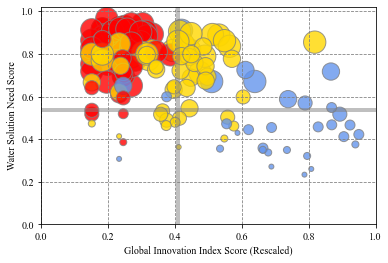

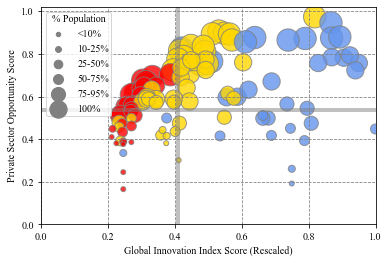

In [71]:
# Choose level of WSN/PrivateOI
Level = 'Med'
#Level = 'ModHi'
#Level = 'High'

plt.rcParams["font.family"] = "Times New Roman"

Area_lim = 25000
Country_table_nomin = Country_table_nomin[Country_table_nomin["ID"] > 0.0]
Country_table_nomin = Country_table_nomin[Country_table_nomin["Area"] > Area_lim]
Country_table_nomin = Country_table_nomin[Country_table_nomin["EE_Adj"] > 0.0]
Country_table_nomin = Country_table_nomin[Country_table_nomin["WIN"] > 0.0]

gii_median = Country_table_nomin.loc[Country_table_nomin.EE_Adj > 0,"EE_Adj"].median()
gii_mean = Country_table_nomin.loc[Country_table_nomin.EE_Adj > 0,"EE_Adj"].mean()
gii_min =  Country_table_nomin.loc[Country_table_nomin.EE_Adj > 0,"EE_Adj"].min()
WIN_median = Country_table_nomin.loc[Country_table_nomin.WIN > 0,"WIN"].median()
WIN_mean = Country_table_nomin.loc[Country_table_nomin.WIN > 0,"WIN"].mean()
PrivateOI_median = Country_table_nomin.loc[Country_table_nomin.PrivateOI > 0,"PrivateOI"].median()
PrivateOI_mean = Country_table_nomin.loc[Country_table_nomin.PrivateOI > 0,"PrivateOI"].mean()

pop_WIN_Q1 = np.where((WINNORM_CDF > WIN_median ), np.where((gii <= gii_median ), popden, 0.00), 0.00)
pop_WIN_Q2 = np.where((WINNORM_CDF > WIN_median ), np.where((gii > gii_median ), popden, 0.00), 0.00)
pop_WIN_Q3 = np.where((WINNORM_CDF <= WIN_median ), np.where((gii <= gii_median ), popden, 0.00), 0.00)
pop_WIN_Q4 = np.where((WINNORM_CDF <= WIN_median ), np.where((gii > gii_median ), popden, 0.00), 0.00)

pop_PrivateOI_Q1 = np.where((PrivateOINORM_CDF > PrivateOI_median ), np.where((gii <= gii_median ), popden, 0.00), 0.00)
pop_PrivateOI_Q2 = np.where((PrivateOINORM_CDF > PrivateOI_median ), np.where((gii > gii_median ), popden, 0.00), 0.00)
pop_PrivateOI_Q3 = np.where((PrivateOINORM_CDF <= PrivateOI_median ), np.where((gii <= gii_median ), popden, 0.00), 0.00)
pop_PrivateOI_Q4 = np.where((PrivateOINORM_CDF <= PrivateOI_median ), np.where((gii > gii_median ), popden, 0.00), 0.00)

Country_table_nomin['Phaseplot_Quadrant'] = np.where((Country_table_nomin.WIN > WIN_median ), np.where((Country_table_nomin.EE_Adj <= gii_median ), 1, 2), np.where((Country_table_nomin.EE_Adj <= gii_median ), 3, 4))
Country_table_nomin['Phaseplot_QuadrantOppPrivateOI'] = np.where((Country_table_nomin.PrivateOI > PrivateOI_median ), np.where((Country_table_nomin.EE_Adj <= gii_median ), 1, 2), np.where((Country_table_nomin.EE_Adj <= gii_median ), 3, 4))

if Level == 'ModHi':
    c_var = 'WINModHiPopDen'
    Country_table_nomin['WINColorModHigh'] = Country_table_nomin.apply(bubbcol, axis=1)
    c_var = 'PrivateOIModHiPopDen'
    Country_table_nomin['PrivateOIColorModHigh'] = Country_table_nomin.apply(bubbcol, axis=1)
elif Level == 'Med':
    c_var = 'WINMedPopDen'
    Country_table_nomin['WINColorMed'] = Country_table_nomin.apply(bubbcol, axis=1)
    c_var = 'PrivateOIMedPopDen'
    Country_table_nomin['PrivateOIColorMed'] = Country_table_nomin.apply(bubbcol, axis=1)
elif Level == 'High':
    c_var = 'WINHighPopDen'
    Country_table_nomin['WINColorHigh'] = Country_table_nomin.apply(bubbcol, axis=1)
    c_var = 'PrivateOIHighPopDen'
    Country_table_nomin['PrivateOIColorHigh'] = Country_table_nomin.apply(bubbcol, axis=1)

Country_table_nomin['WINRank'] = (rankdata(Country_table_nomin['WIN'], method='dense'))
Country_table_nomin['PrivateOIRank'] = (rankdata(Country_table_nomin['PrivateOI'], method='dense'))
Country_table_nomin['WINRank'] = Country_table_nomin['WINRank'].max() - Country_table_nomin['WINRank']  + 1
Country_table_nomin['PrivateOIRank'] = Country_table_nomin['PrivateOIRank'].max() - Country_table_nomin['PrivateOIRank']  + 1

# CHOOSE WHICH COUNTRY TABLE TO USE IN PHASE PLOT, WILL PLOT test_cnty
test_cnty = Country_table_nomin

#
# PLOTTING WIN X GII
#

if Level == 'ModHi':
    test_plot = test_cnty[(test_cnty["WINModHiPopDen"] > 0.0)]
    test_plot = test_plot.sort_values(by='WINModHiPopDen', ascending=False)
elif Level == 'Med':
    test_plot = test_cnty[(test_cnty["WINMedPopDen"] > 0.0)]
    test_plot = test_plot.sort_values(by='WINMedPopDen', ascending=False)
elif Level == 'High':
    test_plot = test_cnty[(test_cnty["WINHighPopDen"] > 0.0)]
    test_plot = test_plot.sort_values(by='WINHighPopDen', ascending=False)

x = test_plot['EE_Adj']
y = test_plot['WIN']

Labels = 'no'
if Level == 'ModHi':
    c = test_plot['WINColorModHigh']
    s = test_plot['WINModHiPopDen']
    #print(s)
    if Labels == 'yes':
        name = str(susinvopp_graphics) + "WIN_vs_GII_ModHi_label.png"
    else:
        name = str(susinvopp_graphics) + "WIN_vs_GII_ModHi.png"
elif Level == 'Med':
    c = test_plot['WINColorMed']
    s = test_plot['WINMedPopDen']
    #s = test_plot['WIN_med']
    print(s)
    if Labels == 'yes':
        name = str(susinvopp_graphics) + "WIN_vs_GII_Median_label.png"
    else:
        name = str(susinvopp_graphics) + "WIN_vs_GII_Median.png"
elif Level == 'High':
    c = test_plot['WINColorHigh']
    s = test_plot['WINHighPopDen']
    if Labels == 'yes':
        name = str(susinvopp_graphics) + "WIN_vs_GII_High_label.png"
    else:
        name = str(susinvopp_graphics) + "WIN_vs_GII_High.png"

order = np.argsort(s)[::-1]

plt.scatter(x=x,
            y=y,
#            s = np.where(s < 0.1, 50, np.where(s < 0.25, 100, np.where(s < 0.50, 200, np.where(s < 0.75, 400, 800)))),
            s = np.where(s < 0.1, 25, np.where(s < 0.25, 50, np.where(s < 0.50, 100, np.where(s < 0.75, 200, np.where(s < 0.95, 300, 500))))),
            alpha=0.8,
            c=c,
            edgecolors='grey')

#Bubble labels
x,y = test_plot['EE_Adj'], test_plot['WIN']
if Labels == 'yes':
    for i, txt in enumerate(test_plot['Economy']):
        plt.annotate(txt, (x.iloc[i], y.iloc[i]), fontsize=6)

if EE_type == 'GII':
    xlab = 'Global Innovation Index Score (Rescaled)'
elif EE_type == 'IWRM':
    xlab = 'SDG 6.5.1 IWRM Score'
elif EE_type == 'AdaptiveCap':
    xlab = 'Adaptive Capacity Index Score'
    
plt.xlabel(str(xlab))
plt.ylabel('Water Solution Need Score')
# plt.xlim(0.2, 1.0)
# plt.ylim(0.3, 1.0)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.02)

sizes = [50*(i+1.) for i in range(0, 3)]
bubble_size_list = [35, 75, 100, 200, 300]
bubble_cat_list = ['<25%', '25-50%', '50-75%', '75-99%', '100%']
bubble_color_list = ['gray', 'gray', 'gray', 'gray', 'gray']

l = []
for i in range(0,len(bubble_cat_list)):
    l.append(plt.scatter([], [], s=bubble_size_list[i], edgecolors='grey', c=bubble_color_list[i]))

x_line = gii_mean
y_line = PrivateOI_mean
plt.plot([0, 1.0], [y_line, y_line], color='grey', linestyle='solid', linewidth=4, alpha = 0.5)
plt.plot([x_line, x_line], [0, 1.02], color='grey', linestyle='solid', linewidth=4, alpha = 0.5)
plt.grid(visible=True, which='major', color='grey', linestyle='dashed')

fig = plt.gcf()
plt.savefig(name, dpi=(250), bbox_inches='tight')

plt.show()

#
# PLOTTING PrivateOI X GII
#

if Level == 'ModHi':
    test_plot = test_cnty[(test_cnty["PrivateOIModHiPopDen"] > 0.0)]
    test_plot = test_plot.sort_values(by='PrivateOIModHiPopDen', ascending=False)
elif Level == 'Med':
    test_plot = test_cnty[(test_cnty["PrivateOIMedPopDen"] > 0.0)]
    test_plot = test_plot.sort_values(by='PrivateOIMedPopDen', ascending=False)
elif Level == 'High':
    test_plot = test_cnty[(test_cnty["PrivateOIHighPopDen"] > 0.0)]
    test_plot = test_plot.sort_values(by='PrivateOIHighPopDen', ascending=False)

x = test_plot['EE_Adj']
y = test_plot['PrivateOI']

Labels = 'no'
if Level == 'ModHi':
    c = test_plot['PrivateOIColorModHigh']
    s = test_plot['PrivateOIModHiPopDen']
    if Labels == 'yes':
        name = str(susinvopp_graphics) + "PrivateOI_vs_GII_ModHi_label.png"
    else:
        name = str(susinvopp_graphics) + "PrivateOI_vs_GII_ModHi.png"
elif Level == 'Med':
    c = test_plot['PrivateOIColorMed']
    s = test_plot['PrivateOIMedPopDen']
    #s = test_plot['PrivateOI_med']
    if Labels == 'yes':
        name = str(susinvopp_graphics) + "PrivateOI_vs_GII_Median_label.png"
    else:
        name = str(susinvopp_graphics) + "PrivateOI_vs_GII_Median.png"
elif Level == 'High':
    c = test_plot['PrivateOIColorHigh']
    s = test_plot['PrivateOIHighPopDen']
    if Labels == 'yes':
        name = str(susinvopp_graphics) + "PrivateOI_vs_GII_High_label.png"
    else:
        name = str(susinvopp_graphics) + "PrivateOI_vs_GII_High.png"

plt.scatter(x=x,
            y=y,
            s = np.where(s < 0.1, 25, np.where(s < 0.25, 50, np.where(s < 0.50, 100, np.where(s < 0.75, 200, np.where(s < 0.95, 300, 500))))),
            alpha=0.8,
            c=c,
            edgecolors='grey')

#Bubble labels
x,y = test_plot['EE_Adj'], test_plot['PrivateOI']
if Labels == 'yes':
    for i, txt in enumerate(test_plot['Economy']):
        plt.annotate(txt, (x.iloc[i], y.iloc[i]), fontsize=6)

plt.xlabel(str(xlab))
plt.ylabel('Private Sector Opportunity Score')
# plt.xlim(0.2, 1.0)
# plt.ylim(0.3, 1.0)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.02)

sizes = [50*(i+1.) for i in range(0, 3)]
bubble_size_list = [20, 35, 75, 100, 200, 300]
bubble_cat_list = ['<10%', '10-25%', '25-50%','50-75%', '75-95%', '100%']
bubble_color_list = ['gray', 'gray', 'gray', 'gray', 'gray', 'gray']

l = []
for i in range(0,len(bubble_cat_list)):
    l.append(plt.scatter([], [], s=bubble_size_list[i], edgecolors='grey', c=bubble_color_list[i]))

leg = plt.legend(l, bubble_cat_list, ncol=1, frameon=True, fontsize=10, handlelength=2, loc = 'upper left', borderpad = 0.2, handletextpad=1, title='% Population', scatterpoints = 1)

x_line = gii_mean
y_line = PrivateOI_mean
plt.plot([0.0, 1.0], [y_line, y_line], color='grey', linestyle='solid', linewidth=4, alpha = 0.5)
plt.plot([x_line, x_line], [0, 1.02], color='grey', linestyle='solid', linewidth=4, alpha = 0.5)
plt.grid(visible=True, which='major', color='grey', linestyle='dashed')

fig = plt.gcf()
plt.savefig(name, dpi=(250), bbox_inches='tight')

plt.show()


# Output Rasters

## Output spatial array raster data for Figures 1, 2, 3 and 5 and relevant interim raster data to GeoTiffs

All model output raster data is saved to Data/Model_Output/rasters. Total Water Threat and Water Threat theme raster data have consistent names and are stored under folders noted below:

| Water Threat | Raster location
| --- | --- |
| Total Human Water Security (HWS) | Data/Model_Output/rasters/HWS
| Water Resource Development (WRD) | Data/Model_Output/rasters/WRD
| Pollution (PO) | Data/Model_Output/rasters/PO
| Catchment Disturbance (CD) | Data/Model_Output/rasters/CD
| Biotic Factors (BF) | Data/Model_Output/rasters/BF

In [66]:
# Enabling Environment
outname = susinvopp_gisdata + 'Enabling_Environment_' + str(EE_type) + '.tif'
save2File(gii[ :, :], outname, nrows, ncols, geotr)

# Adjusted River Threat, Country aggregates of River Threat and IBF 
outname = susinvopp_out + 'AdjThreat.tif'
save2File(ahws[  :, :], outname, nrows, ncols, geotr)
outname = susinvopp_gisdata + 'AdjThreat_Country_Mean.tif'
save2File(ahwsstat[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_gisdata + 'IBF_Country_Max.tif'
save2File(ibfstat[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_gisdata + 'IBF_Country_Mean.tif'
save2File(ibfstat_index[ :, :], outname, nrows, ncols, geotr)

# Population density from downstream and local GPW4 population rasters
outname = susinvopp_gisdata + 'gpw4_dwnpopden_2020_6m.tif'
save2File(popden[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_gisdata + 'gpw4_locpopden_2020_6m.tif'
save2File(localpopden[ :, :], outname, nrows, ncols, geotr)

# Figure 1: Investment Needs and Opps CDF
outname = susinvopp_out + 'WIN_CDF.tif'
save2File(WINNORM_CDF[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_gisdata + 'GII_6m.tif'
save2File(gii[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_out + 'PrivateOI_CDF.tif'
save2File(PrivateOINORM_CDF[ :, :], outname, nrows, ncols, geotr)

# Figures 2, 3 and SI-Fig 2: Investment Needs and Opps X POP
outname = susinvopp_out + 'WIN_dwnpop_low_6m.tif'
save2File(popd_WINNORM_CDF_Low[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_out + 'WIN_dwnpop_mod_6m.tif'
save2File(popd_WINNORM_CDF_Mod[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_out + 'WIN_dwnpop_high_6m.tif'
save2File(popd_WINNORM_CDF_High[ :, :], outname, nrows, ncols, geotr)

outname = susinvopp_out + 'PrivateOI_dwnpop_low_6m.tif'
save2File(popd_PrivateOINORM_CDF_Low[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_out + 'PrivateOI_dwnpop_mod_6m.tif'
save2File(popd_PrivateOINORM_CDF_Mod[ :, :], outname, nrows, ncols, geotr)
outname = susinvopp_out + 'PrivateOI_dwnpop_high_6m.tif'
save2File(popd_PrivateOINORM_CDF_High[ :, :], outname, nrows, ncols, geotr)


## Use the link below to return to the Water Threat list if you wish to run a different water threat option

[Go to Water Threat List](#goto_threat_list)